# Предсказание выживаемости на Титанике 🚢

## Введение

В этом ноутбуке мы познакомимся с **полным циклом работы с данными** в машинном обучении:

1. **EDA (Exploratory Data Analysis)** - исследовательский анализ данных
2. **Data Preprocessing** - предобработка данных
3. **Feature Engineering** - создание новых признаков
4. **Modeling** - построение и оценка модели

**Наша задача:** по информации о пассажире Титаника (возраст, пол, класс билета и т.д.) предсказать, выжил ли он в катастрофе.

Это классическая задача бинарной классификации, которая отлично подходит для изучения основ Data Science!


## 1. Импорт библиотек


In [5]:
# Библиотеки для работы с данными
import pandas as pd

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## 2. Загрузка данных

Датасет Титаник содержит информацию о пассажирах печально известного корабля, затонувшего в 1912 году.


In [6]:
# Загружаем датасет Титаник из seaborn
df = sns.load_dataset('titanic')

# Посмотрим на первые строки
print("Первые 5 строк датасета:")
print(df.head())
print(f"\nРазмер датасета: {df.shape[0]} пассажиров, {df.shape[1]} признаков")


Первые 5 строк датасета:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Размер датасета: 891 пассажиров, 15 признаков


## 3. EDA (Exploratory Data Analysis)

EDA - это процесс исследования данных для понимания их структуры, поиска закономерностей и выявления проблем.

### 3.1 Обзор данных

Начнем с общего обзора: какие признаки есть, какие типы данных, сколько пропусков.


In [7]:
# Информация о датасете
print("Информация о типах данных и пропусках:")
print(df.info())

print("\n" + "="*60)
print("\nОписание признаков:")
print("- survived: выжил (1) или нет (0) - ЦЕЛЕВАЯ ПЕРЕМЕННАЯ")
print("- pclass: класс билета (1 = первый, 2 = второй, 3 = третий)")
print("- sex: пол пассажира")
print("- age: возраст в годах")
print("- sibsp: количество siblings/spouses (братьев/сестер/супругов) на борту")
print("- parch: количество parents/children (родителей/детей) на борту")
print("- fare: стоимость билета")
print("- embarked: порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton)")
print("- class: дублирует pclass в текстовом виде")
print("- who: man, woman, child")
print("- adult_male: является ли взрослым мужчиной")
print("- deck: палуба каюты")
print("- embark_town: город посадки")
print("- alive: yes/no (дублирует survived)")
print("- alone: путешествовал ли один")


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


Описание признаков:
- survived: в

### 3.2 Анализ пропущенных значений

Пропущенные значения (NaN, missing values) - это распространенная проблема в реальных данных. Важно понять, где и сколько их.


Признаки с пропущенными значениями:
    Признак  Пропусков  Процент
       deck        688    77.22
        age        177    19.87
   embarked          2     0.22
embark_town          2     0.22


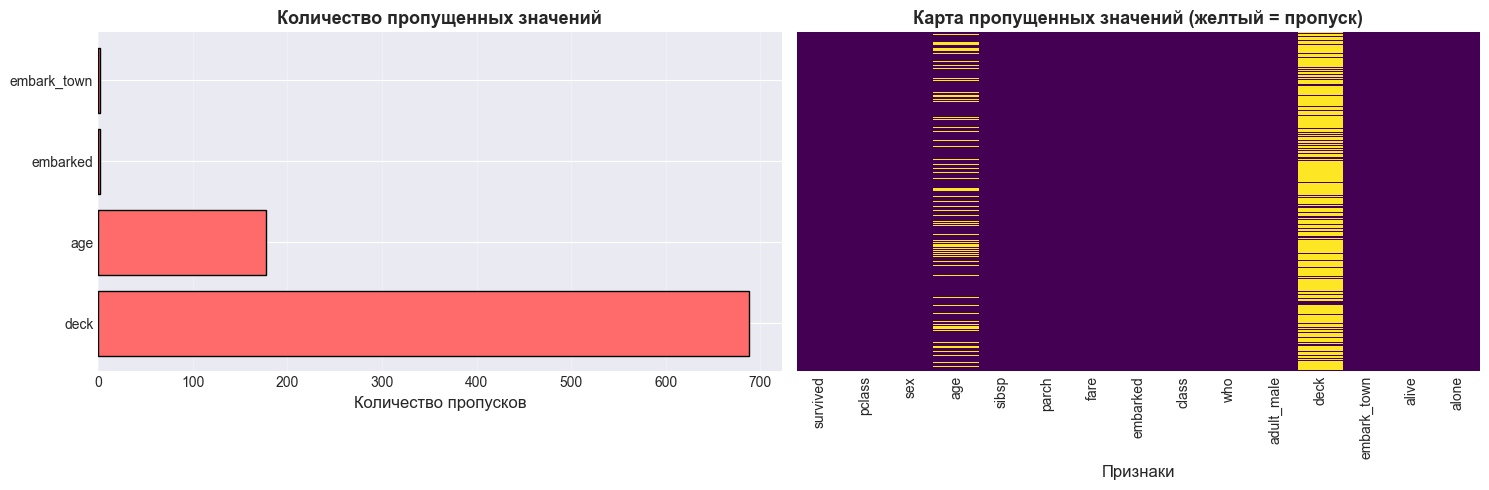

In [8]:
# Подсчет пропусков
missing_data = pd.DataFrame({
    'Признак': df.columns,
    'Пропусков': df.isnull().sum(),
    'Процент': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

print("Признаки с пропущенными значениями:")
print(missing_data.to_string(index=False))

# Визуализация пропусков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Bar chart пропусков
if not missing_data.empty:
    axes[0].barh(missing_data['Признак'], missing_data['Пропусков'], color='#FF6B6B', edgecolor='black')
    axes[0].set_xlabel('Количество пропусков', fontsize=12)
    axes[0].set_title('Количество пропущенных значений', fontsize=13, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

# График 2: Heatmap пропусков
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=axes[1])
axes[1].set_title('Карта пропущенных значений (желтый = пропуск)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Признаки', fontsize=12)

plt.tight_layout()
plt.show()


### 3.3 Анализ целевой переменной (Survived)

Посмотрим на распределение выживших и погибших:


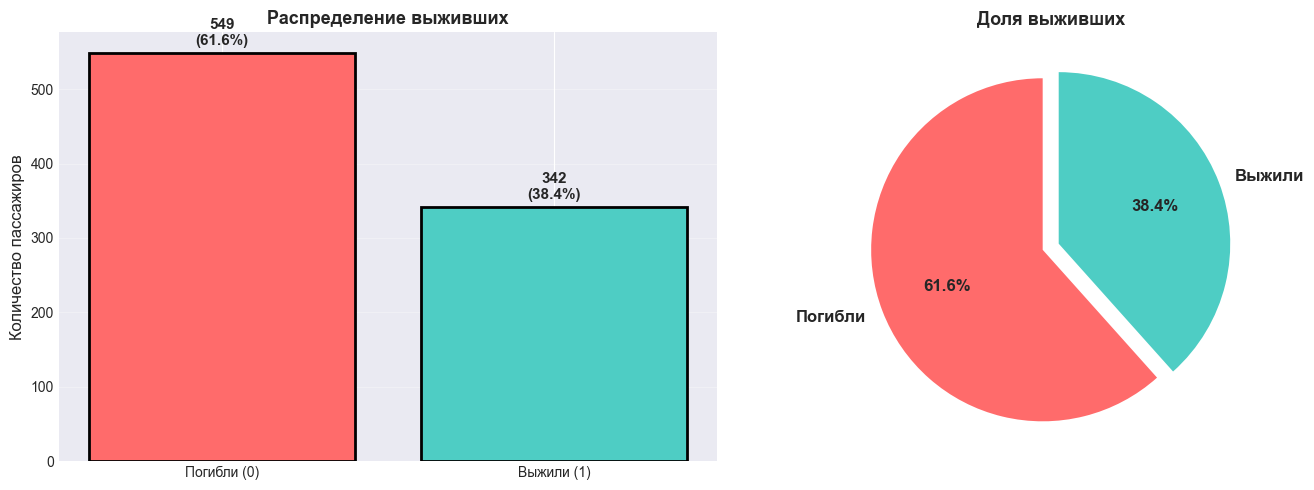

Общая выживаемость: 38.4%
Погибло: 549 пассажиров (61.6%)
Выжило: 342 пассажиров (38.4%)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Count plot
survival_counts = df['survived'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
axes[0].bar(['Погибли (0)', 'Выжили (1)'], survival_counts.values, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Количество пассажиров', fontsize=12)
axes[0].set_title('Распределение выживших', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (val, pct) in enumerate(zip(survival_counts.values, survival_counts.values / len(df) * 100)):
    axes[0].text(i, val + 10, f'{val}\n({pct:.1f}%)', ha='center', fontweight='bold', fontsize=11)

# График 2: Pie chart
axes[1].pie(survival_counts.values, labels=['Погибли', 'Выжили'], autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05),
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Доля выживших', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Общая выживаемость: {df['survived'].mean()*100:.1f}%")
print(f"Погибло: {survival_counts[0]} пассажиров ({survival_counts[0]/len(df)*100:.1f}%)")
print(f"Выжило: {survival_counts[1]} пассажиров ({survival_counts[1]/len(df)*100:.1f}%)")


### 3.4 Анализ категориальных признаков

Посмотрим, как различные признаки влияют на выживаемость.


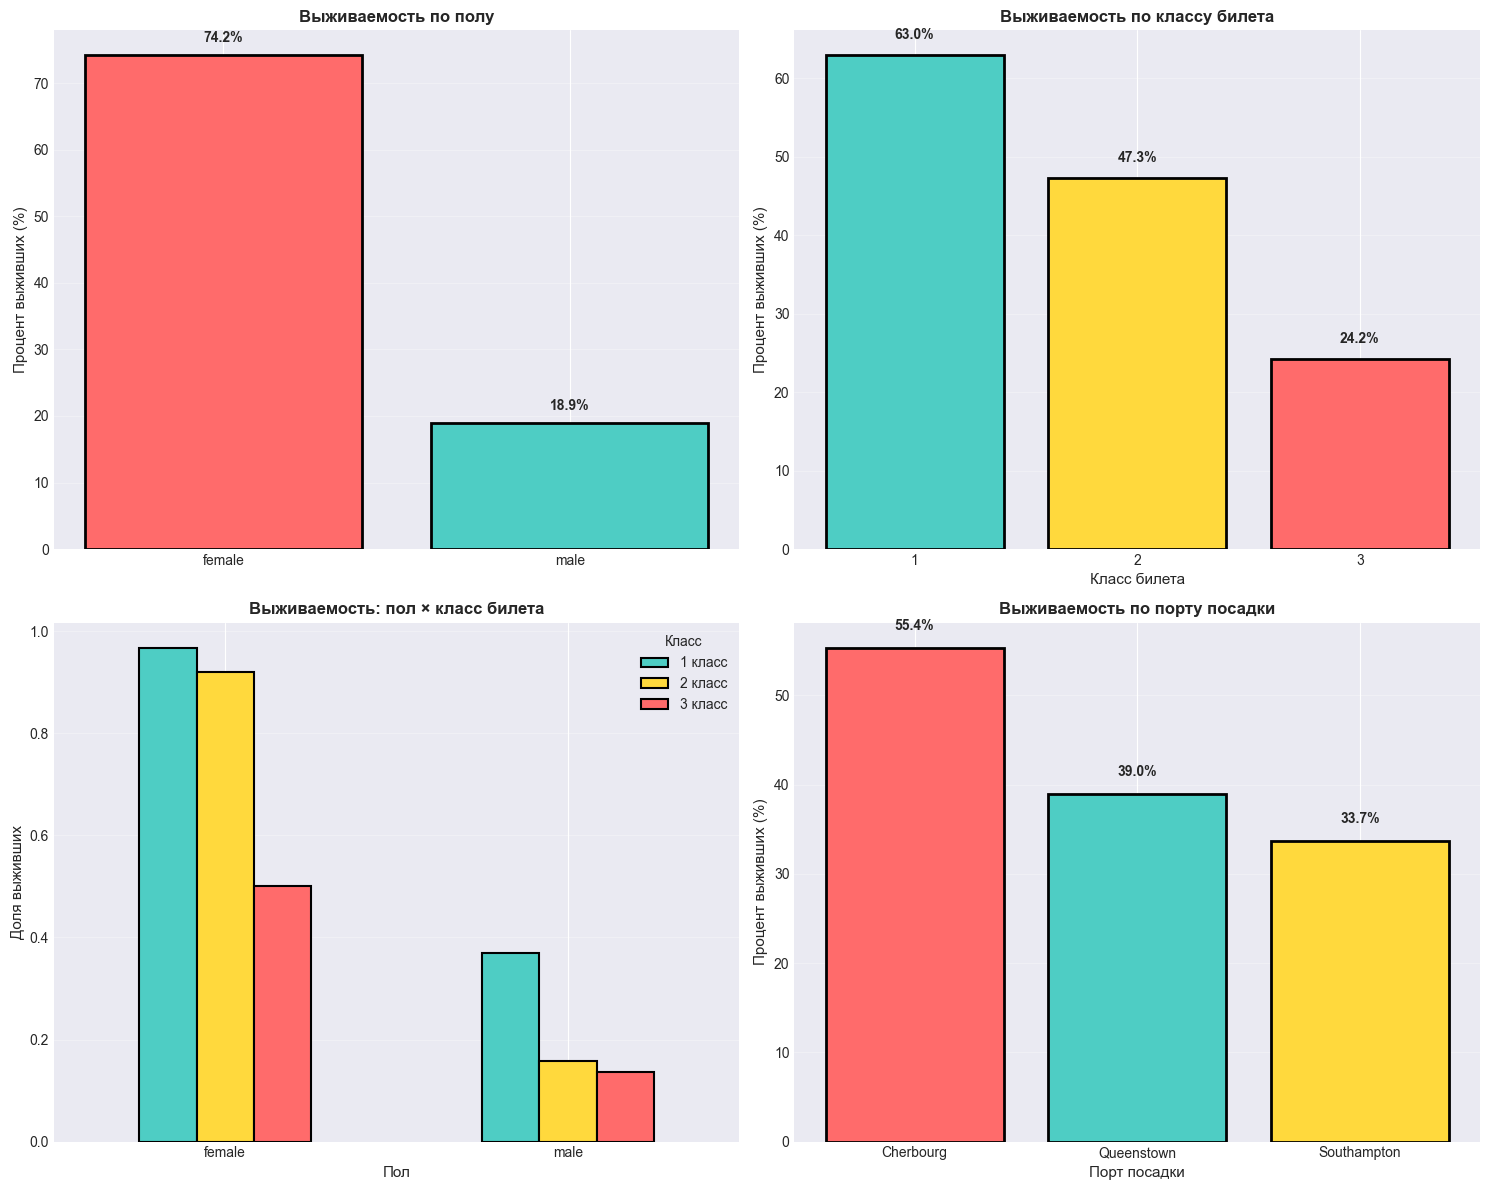

📊 Ключевые наблюдения:
- Женщины выживали чаще (74.2% vs 18.9%)
- Пассажиры 1 класса выживали чаще (63.0% vs 24.2% в 3 классе)
- Комбинация признаков важна: женщины из 1 класса имели максимальные шансы на выживание


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Выживаемость по полу
sex_survival = df.groupby('sex')['survived'].agg(['sum', 'count', 'mean'])
axes[0, 0].bar(sex_survival.index, sex_survival['mean'] * 100, color=['#FF6B6B', '#4ECDC4'], 
               edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Процент выживших (%)', fontsize=11)
axes[0, 0].set_title('Выживаемость по полу', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(sex_survival.iterrows()):
    axes[0, 0].text(i, row['mean']*100 + 2, f"{row['mean']*100:.1f}%", ha='center', fontweight='bold')

# График 2: Выживаемость по классу билета
pclass_survival = df.groupby('pclass')['survived'].agg(['sum', 'count', 'mean'])
colors_class = ['#4ECDC4', '#FFD93D', '#FF6B6B']
axes[0, 1].bar(pclass_survival.index.astype(str), pclass_survival['mean'] * 100, 
               color=colors_class, edgecolor='black', linewidth=2)
axes[0, 1].set_xlabel('Класс билета', fontsize=11)
axes[0, 1].set_ylabel('Процент выживших (%)', fontsize=11)
axes[0, 1].set_title('Выживаемость по классу билета', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(pclass_survival.iterrows()):
    axes[0, 1].text(i, row['mean']*100 + 2, f"{row['mean']*100:.1f}%", ha='center', fontweight='bold')

# График 3: Выживаемость по полу И классу
survival_by_sex_class = df.groupby(['sex', 'pclass'])['survived'].mean().unstack()
survival_by_sex_class.plot(kind='bar', ax=axes[1, 0], color=colors_class, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('Пол', fontsize=11)
axes[1, 0].set_ylabel('Доля выживших', fontsize=11)
axes[1, 0].set_title('Выживаемость: пол × класс билета', fontsize=12, fontweight='bold')
axes[1, 0].legend(title='Класс', labels=['1 класс', '2 класс', '3 класс'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Выживаемость по порту посадки
embarked_survival = df.groupby('embarked')['survived'].mean()
axes[1, 1].bar(embarked_survival.index, embarked_survival.values * 100, 
               color=['#FF6B6B', '#4ECDC4', '#FFD93D'], edgecolor='black', linewidth=2)
axes[1, 1].set_xlabel('Порт посадки', fontsize=11)
axes[1, 1].set_ylabel('Процент выживших (%)', fontsize=11)
axes[1, 1].set_title('Выживаемость по порту посадки', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(embarked_survival.items()):
    axes[1, 1].text(i, val*100 + 2, f"{val*100:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Ключевые наблюдения:")
print(f"- Женщины выживали чаще ({sex_survival.loc['female', 'mean']*100:.1f}% vs {sex_survival.loc['male', 'mean']*100:.1f}%)")
print(f"- Пассажиры 1 класса выживали чаще ({pclass_survival.loc[1, 'mean']*100:.1f}% vs {pclass_survival.loc[3, 'mean']*100:.1f}% в 3 классе)")
print("- Комбинация признаков важна: женщины из 1 класса имели максимальные шансы на выживание")


### 3.5 Анализ числовых признаков


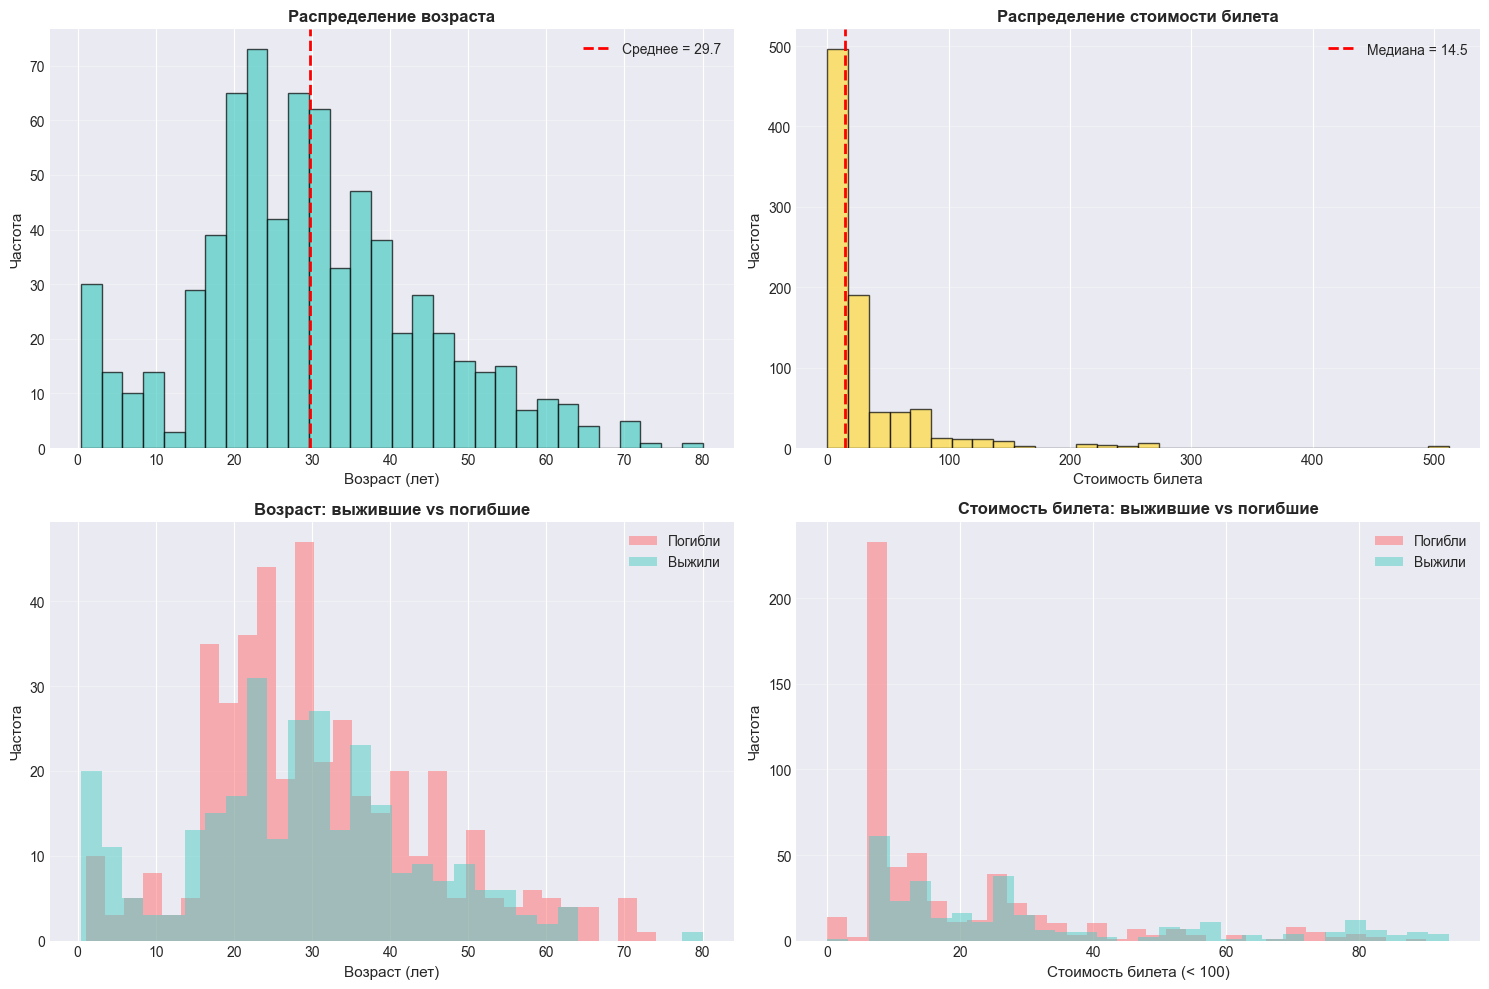

📊 Наблюдения:
- Средний возраст: 29.7 лет
- Средний возраст выживших: 28.3 лет
- Средний возраст погибших: 30.6 лет
- Медианная стоимость билета: 14.45


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Распределение возраста
axes[0, 0].hist(df['age'].dropna(), bins=30, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее = {df["age"].mean():.1f}')
axes[0, 0].set_xlabel('Возраст (лет)', fontsize=11)
axes[0, 0].set_ylabel('Частота', fontsize=11)
axes[0, 0].set_title('Распределение возраста', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: Распределение стоимости билета
axes[0, 1].hist(df['fare'].dropna(), bins=30, color='#FFD93D', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['fare'].median(), color='red', linestyle='--', linewidth=2, label=f'Медиана = {df["fare"].median():.1f}')
axes[0, 1].set_xlabel('Стоимость билета', fontsize=11)
axes[0, 1].set_ylabel('Частота', fontsize=11)
axes[0, 1].set_title('Распределение стоимости билета', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Возраст vs выживаемость
df[df['survived']==0]['age'].dropna().hist(bins=30, alpha=0.5, label='Погибли', ax=axes[1, 0], color='#FF6B6B')
df[df['survived']==1]['age'].dropna().hist(bins=30, alpha=0.5, label='Выжили', ax=axes[1, 0], color='#4ECDC4')
axes[1, 0].set_xlabel('Возраст (лет)', fontsize=11)
axes[1, 0].set_ylabel('Частота', fontsize=11)
axes[1, 0].set_title('Возраст: выжившие vs погибшие', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Стоимость билета vs выживаемость (ограничиваем до 100 для лучшей видимости)
df_fare = df[df['fare'] < 100]
df_fare[df_fare['survived']==0]['fare'].hist(bins=30, alpha=0.5, label='Погибли', ax=axes[1, 1], color='#FF6B6B')
df_fare[df_fare['survived']==1]['fare'].hist(bins=30, alpha=0.5, label='Выжили', ax=axes[1, 1], color='#4ECDC4')
axes[1, 1].set_xlabel('Стоимость билета (< 100)', fontsize=11)
axes[1, 1].set_ylabel('Частота', fontsize=11)
axes[1, 1].set_title('Стоимость билета: выжившие vs погибшие', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Наблюдения:")
print(f"- Средний возраст: {df['age'].mean():.1f} лет")
print(f"- Средний возраст выживших: {df[df['survived']==1]['age'].mean():.1f} лет")
print(f"- Средний возраст погибших: {df[df['survived']==0]['age'].mean():.1f} лет")
print(f"- Медианная стоимость билета: {df['fare'].median():.2f}")


## 4. Data Preprocessing (Предобработка данных)

Предобработка - это подготовка данных для машинного обучения. Включает:
- Обработку пропущенных значений
- Удаление ненужных признаков
- Кодирование категориальных переменных

### 4.1 Создание копии данных для обработки


In [12]:
# Создаем копию для обработки
data = df.copy()

# Выбираем только нужные признаки для модели
# Удаляем избыточные и малоинформативные признаки
columns_to_keep = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
data = data[columns_to_keep]

print("Выбранные признаки для модели:")
print(data.columns.tolist())
print(f"\nРазмер данных: {data.shape}")


Выбранные признаки для модели:
['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

Размер данных: (891, 8)


### 4.2 Обработка пропущенных значений

Стратегии заполнения пропусков:
- **Age**: заполним медианой (средним значением)
- **Embarked**: заполним модой (наиболее частым значением)
- **Fare**: пропусков нет, но на всякий случай заполним медианой


In [13]:
print("Пропуски ДО обработки:")
print(data.isnull().sum())

# Заполнение пропусков в возрасте медианой
data['age'].fillna(data['age'].median(), inplace=True)

# Заполнение пропусков в порте посадки модой (наиболее частое значение)
data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)

# Заполнение пропусков в стоимости билета медианой (на всякий случай)
data['fare'].fillna(data['fare'].median(), inplace=True)

print("\nПропуски ПОСЛЕ обработки:")
print(data.isnull().sum())
print("\n✅ Все пропуски обработаны!")


Пропуски ДО обработки:
survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

Пропуски ПОСЛЕ обработки:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

✅ Все пропуски обработаны!


### 4.3 Кодирование категориальных признаков


In [14]:
# Кодирование пола: male=0, female=1
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

# One-Hot кодирование для порта посадки
data = pd.get_dummies(data, columns=['embarked'], prefix='embarked', drop_first=True)

print("Данные после кодирования:")
print(data.head())
print(f"\nИтоговое количество признаков: {data.shape[1] - 1} (без целевой переменной)")


Данные после кодирования:
   survived  pclass  sex   age  sibsp  parch     fare  embarked_Q  embarked_S
0         0       3    0  22.0      1      0   7.2500       False        True
1         1       1    1  38.0      1      0  71.2833       False       False
2         1       3    1  26.0      0      0   7.9250       False        True
3         1       1    1  35.0      1      0  53.1000       False        True
4         0       3    0  35.0      0      0   8.0500       False        True

Итоговое количество признаков: 8 (без целевой переменной)


## 5. Feature Engineering (Создание признаков)


Feature Engineering - это создание новых признаков из существующих для улучшения качества модели.

<div style="text-align: center">
    <img src="figures/ml-geometry.png" width="700"/>
</div>

### 5.1 Создание признака FamilySize (размер семьи)

Распределение размера семьи:
family_size
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64


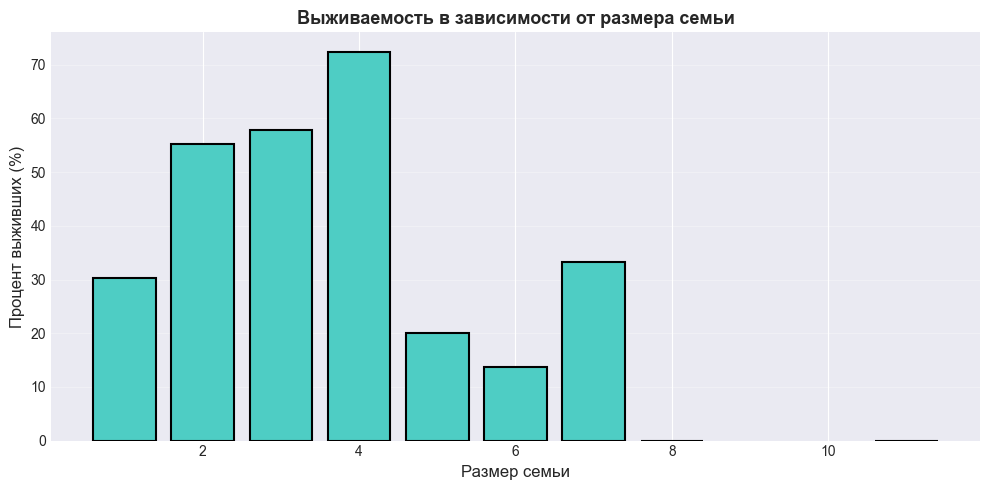


Одиночки выживали с вероятностью: 30.4%
Семьи из 2-4 человек: 57.9%


In [15]:
# FamilySize = количество родственников на борту + сам пассажир
data['family_size'] = data['sibsp'] + data['parch'] + 1

print("Распределение размера семьи:")
print(data['family_size'].value_counts().sort_index())

# Визуализация
plt.figure(figsize=(10, 5))
family_survival = data.groupby('family_size')['survived'].mean()
plt.bar(family_survival.index, family_survival.values * 100, color='#4ECDC4', edgecolor='black', linewidth=1.5)
plt.xlabel('Размер семьи', fontsize=12)
plt.ylabel('Процент выживших (%)', fontsize=12)
plt.title('Выживаемость в зависимости от размера семьи', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nОдиночки выживали с вероятностью: {data[data['family_size']==1]['survived'].mean()*100:.1f}%")
print(f"Семьи из 2-4 человек: {data[data['family_size'].between(2,4)]['survived'].mean()*100:.1f}%")


### 5.2 Создание признака IsAlone (путешествует один)


In [16]:
# IsAlone = 1, если путешествует один, 0 - если с семьей
data['is_alone'] = (data['family_size'] == 1).astype(int)

print(f"Одиноких пассажиров: {data['is_alone'].sum()}")
print(f"С семьей: {(data['is_alone'] == 0).sum()}")
print(f"\nВыживаемость одиноких: {data[data['is_alone']==1]['survived'].mean()*100:.1f}%")
print(f"Выживаемость с семьей: {data[data['is_alone']==0]['survived'].mean()*100:.1f}%")


Одиноких пассажиров: 537
С семьей: 354

Выживаемость одиноких: 30.4%
Выживаемость с семьей: 50.6%


### 5.3 Категоризация возраста


In [17]:
# Создаем возрастные группы
data['age_group'] = pd.cut(data['age'], bins=[0, 12, 18, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Senior'])

print("Распределение по возрастным группам:")
print(data['age_group'].value_counts().sort_index())
print("\nВыживаемость по возрастным группам:")
print(data.groupby('age_group')['survived'].mean().mul(100).round(1))


Распределение по возрастным группам:
age_group
Child      69
Teen       70
Adult     730
Senior     22
Name: count, dtype: int64

Выживаемость по возрастным группам:
age_group
Child     58.0
Teen      42.9
Adult     36.6
Senior    22.7
Name: survived, dtype: float64


## 6. Моделирование

Теперь обучим модель логистической регрессии для предсказания выживаемости.

### 6.1 Подготовка признаков для модели


In [18]:
# Кодируем age_group в числа
data['age_group'] = data['age_group'].cat.codes

# Выбираем признаки для модели (исключаем некоторые для упрощения)
feature_columns = ['pclass', 'sex', 'age', 'fare', 'family_size', 'is_alone', 'age_group', 
                   'embarked_Q', 'embarked_S']

X = data[feature_columns]
y = data['survived']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Количество признаков: {X_train.shape[1]}")


Размер обучающей выборки: 712
Размер тестовой выборки: 179
Количество признаков: 9


### 6.2 Математика логистической регрессии

Логистическая регрессия использует **сигмоидную функцию** для предсказания вероятности принадлежности к классу:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

где $z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$ - линейная комбинация признаков.

**Вероятность выживания:**

$$P(survived = 1 | X) = \frac{1}{1 + e^{-(w_0 + w_1 \cdot pclass + w_2 \cdot sex + ... + w_n \cdot embarked_S)}}$$

Модель обучается так, чтобы найти оптимальные веса $w_0, w_1, ..., w_n$, которые максимизируют вероятность правильной классификации.

### 6.3 Обучение модели


In [19]:
# Создаем и обучаем модель логистической регрессии
model = LogisticRegression(max_iter=1000, random_state=42)

print("🔄 Обучаем модель...")
model.fit(X_train, y_train)
print("✅ Модель обучена!")

# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

print("\nПример предсказаний (первые 10):")
print(f"Реальные значения:      {y_test[:10].values}")
print(f"Предсказанные значения: {y_pred[:10]}")


🔄 Обучаем модель...
✅ Модель обучена!

Пример предсказаний (первые 10):
Реальные значения:      [1 0 0 1 1 1 1 0 1 1]
Предсказанные значения: [0 0 0 1 1 1 1 0 1 1]


### 6.4 Оценка качества модели

Для оценки классификации используем несколько метрик:
- **Accuracy** (точность) - доля правильных предсказаний
- **Precision** (точность положительных) - из предсказанных "выжил", сколько действительно выжило
- **Recall** (полнота) - из тех, кто действительно выжил, сколько модель нашла
- **F1-Score** - среднее гармоническое precision и recall


In [20]:
# Вычисляем точность на обучающей и тестовой выборках
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("📊 МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
print("=" * 60)
print(f"Точность на обучающей выборке: {train_accuracy*100:.2f}%")
print(f"Точность на тестовой выборке:  {test_accuracy*100:.2f}%")
print("\n" + "=" * 60)
print("\nПодробный отчет по классам:")
print(classification_report(y_test, y_pred, target_names=['Погиб', 'Выжил']))


📊 МЕТРИКИ КАЧЕСТВА МОДЕЛИ
Точность на обучающей выборке: 80.34%
Точность на тестовой выборке:  80.45%


Подробный отчет по классам:
              precision    recall  f1-score   support

       Погиб       0.81      0.87      0.84       105
       Выжил       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



### 6.5 Матрица ошибок (Confusion Matrix)

Матрица ошибок показывает, сколько примеров каждого класса модель предсказала правильно и неправильно:
- **True Positive (TP)**: правильно предсказали "выжил"
- **True Negative (TN)**: правильно предсказали "погиб"
- **False Positive (FP)**: ошибочно предсказали "выжил" (на самом деле погиб)
- **False Negative (FN)**: ошибочно предсказали "погиб" (на самом деле выжил)


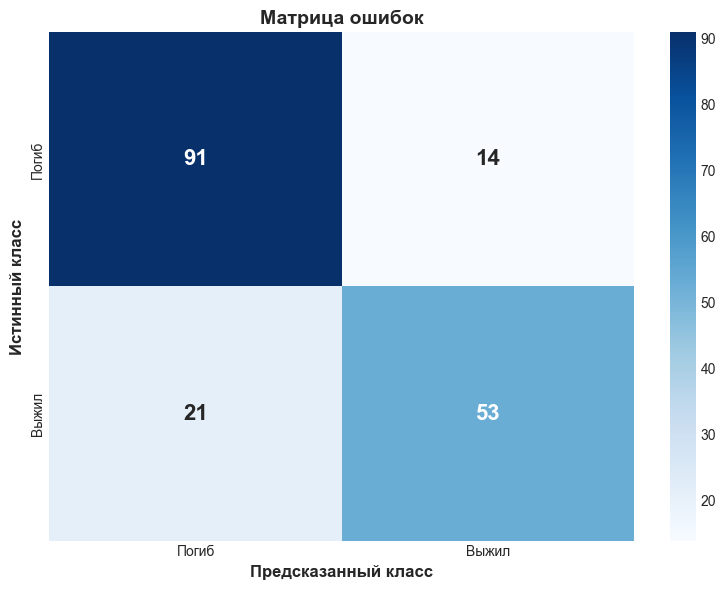

📋 Интерпретация матрицы ошибок:
True Negative (правильно предсказали 'погиб'):  91
False Positive (ошибочно предсказали 'выжил'): 14
False Negative (ошибочно предсказали 'погиб'): 21
True Positive (правильно предсказали 'выжил'): 53


In [21]:
# Создаем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Погиб', 'Выжил'],
            yticklabels=['Погиб', 'Выжил'],
            annot_kws={'size': 16, 'fontweight': 'bold'})
plt.xlabel('Предсказанный класс', fontsize=12, fontweight='bold')
plt.ylabel('Истинный класс', fontsize=12, fontweight='bold')
plt.title('Матрица ошибок', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Расшифровка
print("📋 Интерпретация матрицы ошибок:")
print(f"True Negative (правильно предсказали 'погиб'):  {cm[0,0]}")
print(f"False Positive (ошибочно предсказали 'выжил'): {cm[0,1]}")
print(f"False Negative (ошибочно предсказали 'погиб'): {cm[1,0]}")
print(f"True Positive (правильно предсказали 'выжил'): {cm[1,1]}")


### 6.6 Важность признаков (Feature Importance)

Коэффициенты логистической регрессии показывают, насколько сильно каждый признак влияет на предсказание:
- **Положительный коэффициент** → увеличивает вероятность выживания
- **Отрицательный коэффициент** → уменьшает вероятность выживания
- **Чем больше абсолютное значение**, тем сильнее влияние признака


📊 Коэффициенты признаков:
    Признак  Коэффициент
        sex     2.584483
     pclass    -0.837584
   is_alone    -0.621013
  age_group    -0.557499
family_size    -0.427713
 embarked_S    -0.334454
 embarked_Q    -0.043632
        age    -0.011208
       fare     0.003085


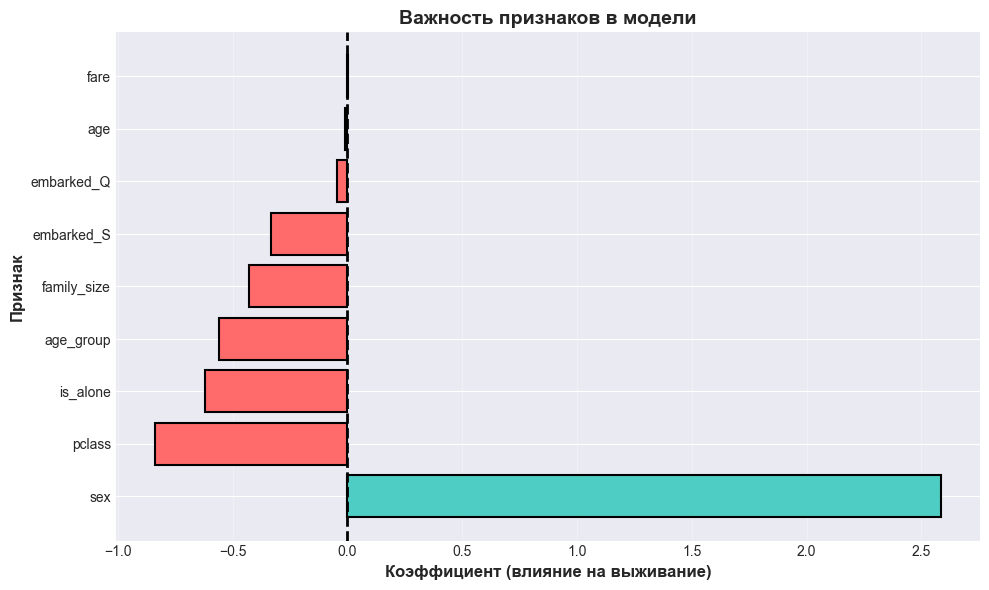


🔍 Интерпретация:
Зеленый цвет = положительное влияние (увеличивает шансы на выживание)
Красный цвет = отрицательное влияние (уменьшает шансы на выживание)

Наиболее важный признак: sex (2.584)


In [22]:
# Получаем коэффициенты модели
coefficients = pd.DataFrame({
    'Признак': feature_columns,
    'Коэффициент': model.coef_[0]
}).sort_values('Коэффициент', key=abs, ascending=False)

print("📊 Коэффициенты признаков:")
print(coefficients.to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 6))
colors = ['#4ECDC4' if x > 0 else '#FF6B6B' for x in coefficients['Коэффициент']]
plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Коэффициент (влияние на выживание)', fontsize=12, fontweight='bold')
plt.ylabel('Признак', fontsize=12, fontweight='bold')
plt.title('Важность признаков в модели', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=2, linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Интерпретация:")
print("Зеленый цвет = положительное влияние (увеличивает шансы на выживание)")
print("Красный цвет = отрицательное влияние (уменьшает шансы на выживание)")
print(f"\nНаиболее важный признак: {coefficients.iloc[0]['Признак']} ({coefficients.iloc[0]['Коэффициент']:.3f})")


## 7. Выводы и итоги 🎯

Поздравляем! Вы прошли полный цикл работы Data Scientist над реальной задачей!

### Что мы сделали:

1. **EDA (Exploratory Data Analysis)** ✅
   - Изучили структуру данных
   - Визуализировали распределения
   - Нашли закономерности: женщины и пассажиры 1 класса выживали чаще
   - Обнаружили пропуски в данных

2. **Data Preprocessing (Предобработка)** ✅
   - Заполнили пропуски в Age и Embarked
   - Закодировали категориальные признаки (Sex, Embarked)
   - Отобрали релевантные признаки

3. **Feature Engineering (Создание признаков)** ✅
   - Создали FamilySize (размер семьи)
   - Создали IsAlone (путешествует один)
   - Разбили возраст на категории

4. **Modeling (Моделирование)** ✅
   - Обучили логистическую регрессию
   - Достигли точности ~80% на тестовой выборке
   - Проанализировали важность признаков

### Ключевые находки:

🔑 **Самые важные факторы выживания:**
- **Пол (sex)** - женщины имели гораздо больше шансов
- **Класс билета (pclass)** - пассажиры 1 класса выживали чаще
- **Стоимость билета (fare)** - косвенно связана с классом
- **Возраст (age)** - дети имели больше шансов

### Что можно улучшить:

💡 **Дальнейшие шаги для повышения качества:**
- Попробовать другие модели (Random Forest, Gradient Boosting)
- Создать больше признаков (например, из Name извлечь титул: Mr, Mrs, Miss)
- Провести более тщательный анализ выбросов
- Использовать кросс-валидацию для оценки
- Настроить гиперпараметры модели


### 🚀 Задания для самостоятельной работы:

1. **Попробуйте создать новые признаки:**
   - Извлеките титул из имени (Name): Mr, Mrs, Miss, Master
   - Создайте признак "стоимость билета на человека" = Fare / FamilySize
   
2. **Поэкспериментируйте с заполнением пропусков:**
   - Заполните Age не медианой, а медианой по группам (по полу и классу)
   
3. **Визуализируйте дополнительные зависимости:**
   - Постройте график выживаемости по возрасту (возрастные группы)
   - Исследуйте связь SibSp и Parch с выживаемостью

4. **Сравните с другой моделью:**
   - Попробуйте использовать KNeighborsClassifier из первого ноутбука
   - Сравните результаты с логистической регрессией

---

**Полезные ссылки:**
- [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic)
- [Документация Scikit-learn](https://scikit-learn.org/)
- [Pandas Documentation](https://pandas.pydata.org/)

**Удачи в изучении Machine Learning! 🎓✨**
